In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('/content/drive/MyDrive/lung_disease_prediction/dataset.csv')
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,M,65,1,1,1,2,2,1,2,2,2,2,2,2,1,NO
1,F,55,1,2,2,1,1,2,2,2,1,1,1,2,2,NO
2,F,78,2,2,1,1,1,2,1,2,1,1,2,1,1,YES
3,M,60,2,1,1,1,2,1,2,1,1,2,1,2,2,YES
4,F,80,1,1,2,1,1,2,1,2,1,1,1,1,2,NO


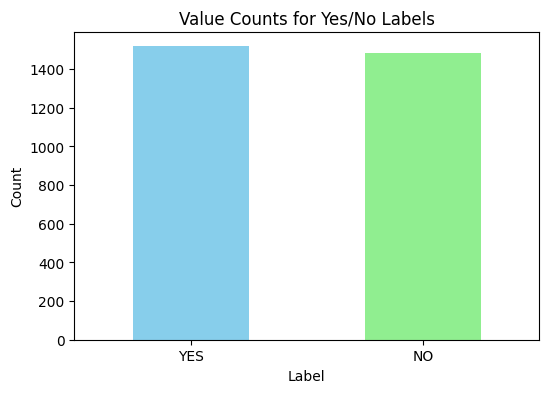

In [8]:
value_counts = df['LUNG_CANCER'].value_counts()

# Create a bar plot
plt.figure(figsize=(6,4))
value_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Value Counts for Yes/No Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

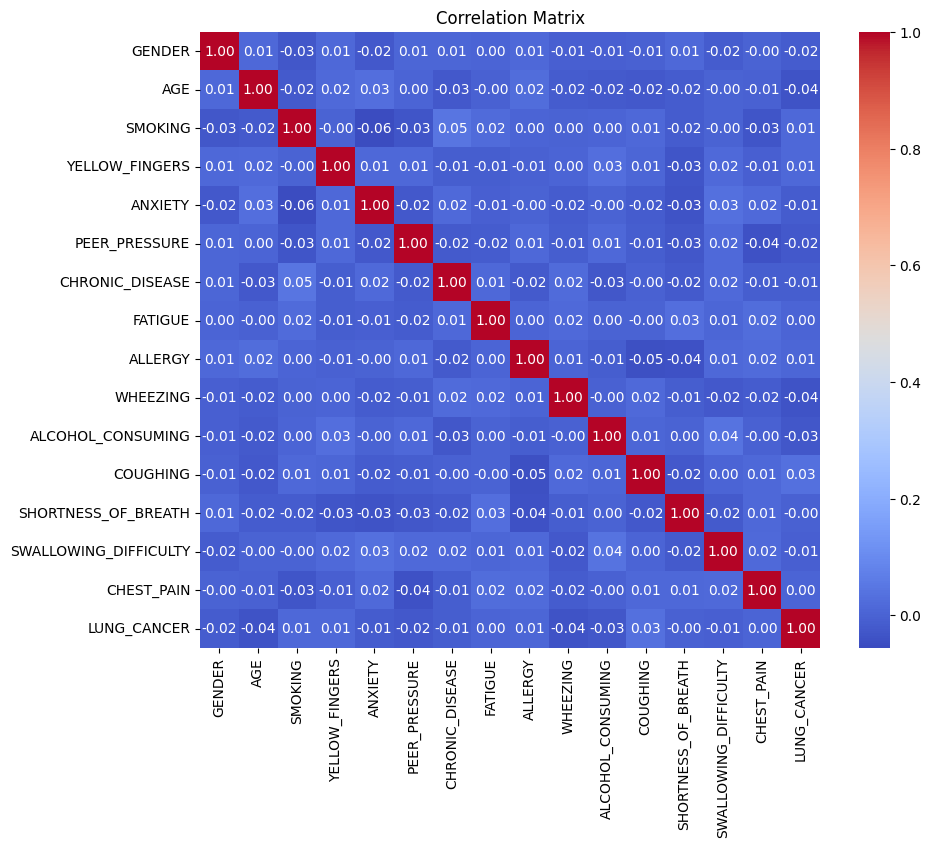

In [45]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])
df['LUNG_CANCER'] = label_encoder.fit_transform(df['LUNG_CANCER'])
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The features do not seem to have any relationship with the output. That's why the accuracy is low

In [47]:
df.columns
X =df[['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC_DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
       'ALCOHOL_CONSUMING', 'COUGHING', 'SHORTNESS_OF_BREATH',
       'SWALLOWING_DIFFICULTY', 'CHEST_PAIN']]
Y= df["LUNG_CANCER"]

In [48]:
df.isnull().sum()

,0
GENDER,0
AGE,0
SMOKING,0
YELLOW_FINGERS,0
ANXIETY,0
PEER_PRESSURE,0
CHRONIC_DISEASE,0
FATIGUE,0
ALLERGY,0
WHEEZING,0


Remove rows with outliers

In [49]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical column
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define a condition to filter out outliers (values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR])
outlier_condition = ~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

df_no_outliers = df[outlier_condition]

# Display the shape of the original and cleaned DataFrame
original_shape = df.shape
cleaned_shape = df_no_outliers.shape

(original_shape, cleaned_shape)


((3000, 16), (3000, 16))

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Use the encoded features (X) and target (Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train individual classifiers
clf1 = LogisticRegression(solver='lbfgs', random_state=1, max_iter=400)
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

# # Define the DNN model
def build_keras_dnn(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='softmax'))  # Binary classification output

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the Keras neural network for binary classification
dnn_model = build_keras_dnn(input_dim=X_train.shape[1])

# Convert Y_train to a numpy array for Keras compatibility
Y_train = np.array(Y_train)

# Fit the DNN model on training data
dnn_model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)

# Predict with the Keras DNN model
dnn_preds = dnn_model.predict(X_test)
dnn_preds = (dnn_preds > 0.5).astype(int)  # Convert probabilities to binary predictions

# For Ensemble Voting Classifier (excluding Keras DNN)
eclf = VotingClassifier(estimators=[
        ('lr', clf1),
        ('dt', clf2),
        ('gnb', clf3)
], voting='soft')

# Fit and evaluate classifiers
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Decision Tree', 'Gaussian NB', 'Ensemble']):
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        print(f"Accuracy: {accuracy:.2f} [{label}]")

# Evaluate the Keras DNN model separately
dnn_accuracy = accuracy_score(Y_test, dnn_preds)
print(f"Accuracy: {dnn_accuracy:.2f} [Keras DNN]")


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Accuracy: 0.52 [Logistic Regression]
Accuracy: 0.49 [Decision Tree]
Accuracy: 0.53 [Gaussian NB]
Accuracy: 0.49 [Ensemble]
Accuracy: 0.50 [Keras DNN]
